In [1]:
import os
from pprint import pprint
import pandas as pd
import numpy as np
from matplotlib import pyplot
from unidecode import unidecode

# Domain Generating Algorithms - EDA

## Context:

Once malicious software has been installed on a system it needs to be told what to do. To receive instructions the malware needs to communicate with a command and control server.
Historically, the domain name of the command and control server was hardcoded into the code of the malware. This made it very easy for cybersecurity professionals to block this communication channel by blacklisting the domain once they discovered it.

To avoid this weakness malware programs have started to use Domain Generating Algorithms (or DGAs).  These algorithms generate a number of random domain names where one of the generated domains is the control server. The infected computed scans through these domains trying to contact each, eventually it will try the correct domain. At this stage, the malware can receive instructions remotely.

The dataset consists of domains that have been labeled:
* `class` - is the domain `legit` or `dga`
* `subclass` - where the `class` is not `legit` this will detail the type of malware that generated the domain. If `legit` the value for this will also be `legit`.

## Objective

If we assume that:
* **True Postive**: Correctly identified a `dga` entry.
* **True Negative**: Correctly identified a `legit` entry.
* **False Positive**: Incorrectly identifed a `dga` entry as a `legit` entry - *Type 1 Error*.
* **False Negative**: Incorrectly identified a `legit` entry as a `dga` entry  - *Type 2 Error*.

We futher assume the **False Postive** as the worst outcome, that we allowed a program to establish a connection to a `dga`.

# Conclusions for Futher Work




## Overall:

* Accuracy alone is not a suffcient metric, rather F1 Score will give a better view of the performance in light of *Type 2 Errors* (False Negatives) being the most undesireable.
* Vowel Counts do not provide a clear boundary between `class` entries. However *Vowel Ratios* have some discriminatory value between the `class` entries. This can be nominally improved if we consider only distinct characters.
* There is some discriminating value in counting the number of digits, in that where the *Vowel Ratio* is zero `dga` domains have an increased likelyhood of having a zero digit count.
* `domain` will be used as the input, as the additional information provided by `host` (e.g. Top Level Domain) would be difficult to action due to `class` imbalances.

## Column Specific

* `domain`
    * Does not contain unique values, due to variation of `host` (e.g. companies with country specific sites), however the `class` and `subclass` values are the same across the duplicated observations of `domain`.
    * The mimimum length character length of a `dga` entry is 12 characters. Furthermore `dga` entries have a greater variation in character length (`~5.94`) compared to `legit` (`~3.3`) - *this could be a useful feature*.
* `host`
    * Although it is possible to split out the Top Level Domain - `tld` (e.g. .com,.ru) the distribution is heavily skewed. Furthermore ~99% of the `tld` do not have observations where the `class` is `dga` - *thus as a feature `tld` would not generalise well*.

## Considerations for Processing Steps

* Convert to lowercase.
* Normalise Unicode to ASCII characters sets.
* Remove all characters that do not fall into the range of `[a-z0-9\-]`.
* Remove all whitespace.
* Remove duplicates.
* create `domain_len`, counting the number of characters in domain.
* create `domain_vowel_count` and `domain_vowel_ratio` - `domain_vowel_count` is not for use the model but rather required for calculating the ratio of characters in the `domain` that are vowels.
* create `domain_digit_count`, counting the number of characters in `domain` that are digits.

# References

![Example of URL parts](https://domain.me/wp-content/uploads/2016/10/IP-domain-1.jpg)

Image Credit: [domain.me](https://domain.me/what-are-domain-names-how-do-they-work/) I will use the above definitions for referring constituiant parts of a "domain".

For the canonical definition of URLs I referred to: [Domain names Implementation and Specification ietf.org](https://tools.ietf.org/html/rfc1035)

For clarification on Unicode characters in DNS: [Internationalisation of DNS - unicode.org](https://unicode.org/faq/idn.html)

# Data Preview and Data Types

In [2]:
os.chdir("../")

In [5]:
data_df = pd.read_csv("data/raw/dga_domains.csv")

In [6]:
data_df.sample(5, random_state = 9000)

,host,domain,class,subclass
79135,myscoresoft.info,myscoresoft,legit,legit
60750,jdiqrjrrjvoitck.ru,jdiqrjrrjvoitck,dga,cryptolocker
121537,viet4rum.com,viet4rum,legit,legit
21615,buzzstream.tv,buzzstream,legit,legit
87732,pbguide.com,pbguide,legit,legit


# Observations on the Data Preview

- `host` contains the SLD and the TLD, it does not seem to contain the subdomain e.g. "www".
- `domain` is just the SLD.
- `class` details if the record is legitimate (`legit`) or the result of a Domain Generating Algorithms (`dga`).
- `subclass` where `class` is `dga` this column details the malware which used the domain. If the `class` is `legit` the value for the column is `legit`.

In [7]:
data_df.shape

(133926, 4)

In [8]:
data_df.dtypes

host        object
domain      object
class       object
subclass    object
dtype: object

In [9]:
data_df.count()

host        133926
domain      133926
class       133926
subclass    133926
dtype: int64

# Missing Values

Before missing data checks, given we're working with only text columns lets eliminate leading and trailing whitespace, and then replace empty strings with a known value (`np.nan`).

In [10]:
for col in data_df.columns:
    data_df[col] = data_df[col].apply(lambda x: str(x).strip())

In [11]:
data_df = data_df.replace({ "": np.nan })

In [12]:
data_df.count()

host        133926
domain      133926
class       133926
subclass    133926
dtype: int64

In [13]:
assert(data_df.dropna(axis = 0, how = "any").shape == data_df.shape)

# Observations on Missing Values

There appear to be no missing values in the dataset.

Although we should check for empty inputs.

# Uniqueness

Based on my understanding of the dataset, I expect the `host` and the `domain` columns to contain unique values.

In [14]:
for col in data_df.columns:
    print(col, "is unique:", data_df[col].is_unique)

host is unique: True
domain is unique: False
class is unique: False
subclass is unique: False


It appears I was mistaken, lets see what is in domain.

In [15]:
domain_values_counts_df = pd.DataFrame(data_df["domain"].value_counts().sort_values(ascending = False)).reset_index()
domain_values_counts_df.columns = ["domain", "occurances"]
domain_values_counts_df.head(10)

,domain,occurances
0,provincia,47
1,travian,46
2,groupon,46
3,trivago,45
4,philips,45
5,careerjet,45
6,mcdonalds,41
7,mercedes-benz,40
8,tripadvisor,40
9,skyscanner,37


What is the distribution of the duplication of `domain`?

In [16]:
domain_values_counts_df["occurances"].describe()

count    114525.000000
mean          1.169404
std           1.076192
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          47.000000
Name: occurances, dtype: float64

It would seem for the majority of the time host and domain are similar. Let's peek at the first 10 entries in our dataset with the most frequently occuring `domain` value.

In [17]:
data_df[data_df["domain"] == domain_values_counts_df.iloc[0]["domain"]].head(10)

,host,domain,class,subclass
92620,provincia.genova.it,provincia,legit,legit
92621,provincia.teramo.it,provincia,legit,legit
92622,provincia.cs.it,provincia,legit,legit
92623,provincia.so.it,provincia,legit,legit
92624,provincia.fe.it,provincia,legit,legit
92625,provincia.udine.it,provincia,legit,legit
92626,provincia.lecco.it,provincia,legit,legit
92627,provincia.le.it,provincia,legit,legit
92628,provincia.treviso.it,provincia,legit,legit
92629,provincia.tn.it,provincia,legit,legit


Based on the above it would seem that the `host` column contains both the Second Level Domain (SLD) and the Top Level Domain (TLD).

From this there are a couple of assumptions:
* Splitting the `host` field on `.` characters and taking the first slice will result in a value equal to the domain.
* For the many entries that share the same domain, they will belong to the same `class` and `subclass`.



In [18]:
data_sld = data_df["host"].apply(lambda x: x.split(".")[0])

Let's validate the first assumption.

In [19]:
assert(np.all(data_sld == data_df["domain"]))

Now for the second. That for grouped by `host` the number of unique values of `class` and `subclass` will equal one.

In [20]:
data_grouped_by_domain_sum_df = data_df[["domain", "class", "subclass"]].groupby("domain").agg(pd.Series.nunique)

In [21]:
data_grouped_by_domain_sum_df.head()

,class,subclass
domain,,
000directory,1,1
000webhost,1,1
001fans,1,1
01-telecharger,1,1
010shangpu,1,1


In [22]:
data_grouped_by_domain_sum_df.sort_values("class", ascending = False)

,class,subclass
domain,,
000directory,1,1
pingwest,1,1
pinkems,1,1
pinkemma,1,1
pinkdino,1,1
...,...,...
freshupnow,1,1
freshtv,1,1
freshthemes,1,1


In [23]:
assert(data_grouped_by_domain_sum_df["class"].max() == 1)

In [24]:
assert(data_grouped_by_domain_sum_df["subclass"].max() == 1)

# Observations on Uniqueness

* `domain` is **not unique**, if it is considered as part of model it would be prudent to remove the duplicated values.

# Data Quality Checks

Given we've got mostly string data let's review the assumptions about the data pertaining to the quality of the data:

* No control characters, such at linebreak or tabs should be present.
* The characterset will be ascii.
* There should be a variety of characters 




In [25]:
validate_text_columns = ["host", "domain"]

## No Control Characters

If we assume that the range of expected characters to be `a-z`, `0-9`, `-`, then we can compare the ordinal values in our dataset to check if they are in this range.

Let's first determine the numeric ranges we need for ascii characters.

In [26]:
ascii_ranges = ["-", ".", "0", "1", "9", "a", "z"]
ascii_ord_ranges = list()
for c in ascii_ranges:
    ascii_ord_ranges.append(ord(c))
    print(c, ord(c))

- 45
. 46
0 48
1 49
9 57
a 97
z 122


Lets create our list of `expected_ords` and test the characters we identified for `ascii_ranges` have their numeric representation therein.

In [27]:
expected_ords = [ord("-"), ord(".")] + list(range(ord("0"), ord("9")+1)) + list(range(ord("a"), ord("z")+ 1))

# a simple check to ensure the range domains we identified are present
for i in ascii_ord_ranges:
    assert(i in expected_ords)

Now to create a new dataframe containing text in domain represented as a sequence of number representing the characters.

Also taking the additional step of converting the text to lower, this is step that will need to be taken in preprocessing.

In [28]:
ord_data_dfs = dict()

for column in validate_text_columns:
    print(column)
    ord_data_dfs[column] = data_df[column].apply(lambda x: [ord(w) for w in x.lower()]).apply(pd.Series)
    display(ord_data_dfs[column].head())

host


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,48.0,48.0,48.0,100.0,105.0,114.0,101.0,99.0,116.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.0,48.0,48.0,119.0,101.0,98.0,104.0,111.0,115.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.0,48.0,49.0,102.0,97.0,110.0,115.0,46.0,99.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,49.0,45.0,116.0,101.0,108.0,101.0,99.0,104.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.0,49.0,48.0,115.0,104.0,97.0,110.0,103.0,112.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


domain


,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,48.0,48.0,48.0,100.0,105.0,114.0,101.0,99.0,116.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.0,48.0,48.0,119.0,101.0,98.0,104.0,111.0,115.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.0,48.0,49.0,102.0,97.0,110.0,115.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,49.0,45.0,116.0,101.0,108.0,101.0,99.0,104.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.0,49.0,48.0,115.0,104.0,97.0,110.0,103.0,112.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's replace the nothing values with a known number that we will permit to be present.

In [29]:
for column in validate_text_columns:
      ord_data_dfs[column] = ord_data_dfs[column].fillna(-1)

In [30]:
unknown_ord_columns = dict()

for column in validate_text_columns:
    print(column)
    unknown_ord_columns[column] = set()

    for ord_column in ord_data_dfs[column].columns:
        try:
            assert(all(ord_data_dfs[column][ord_column].isin(expected_ords + [-1])))
        except AssertionError:
            print(column, "- column:", ord_column, "contained unknown ordinal value")
            unknown_ord_columns[column].add(ord_column)
            continue
      
    print()

host
host - column: 2 contained unknown ordinal value

domain
domain - column: 2 contained unknown ordinal value



What did we miss?

In [31]:
for column in validate_text_columns:
    print(column)
    for ord_column in unknown_ord_columns[column]:    
        unknown_ord_index = (~ord_data_dfs[column][ord_column].isin(expected_ords + [-1]))
        if any(unknown_ord_index):
            print(ord_data_dfs[column].loc[unknown_ord_index][ord_column])
            display(data_df.loc[unknown_ord_index][column])

    print()

host
99692    10.0
Name: 2, dtype: float64


99692    ru\ndercxjvpfswhmtwtcfycaijdufa.ru
Name: host, dtype: object


domain
99692    10.0
Name: 2, dtype: float64


99692    ru\ndercxjvpfswhmtwtcfycaijdufa
Name: domain, dtype: object

Ordinal `10` is a newline.

In [32]:
chr(10)

'\n'

## Observations on Control Characters 
It would seem we have a line break in our dataset. This could be the result of malformed encoding, or some data capture error.

For preprocessing we should: 
* Convert `domain` and `host` to lowercase
* Remove all characters that do not fall within the expected ordinal values for domain.


## Non-ASCII characters

Although we've identified a range of characters we will permit, it does assume that we're operating in an ASCII characters set. If we remove all characters that don't meet this criteria we'll have a fair bit of potential information loss for example: `é` could be viewed as `e`.

Unicode support has been implemented in dns names as per https://unicode.org/faq/idn.html
However for the purposes of dimension reduction we'll assume an ASCII character-set.


Create a normalised copy of the two columns of interest `domain` and `host`, and then compare them to the exisiting columns.

If using Python 3.7+ one could use: https://docs.python.org/3/library/stdtypes.html#str.isascii

In [33]:
! python --version

Python 3.7.1


In [34]:
unidecode_data = dict()

for column in validate_text_columns:
    unidecode_data[column] = data_df[column].apply(unidecode)
    try:
        assert(all(unidecode_data[column] == data_df[column]))
    except AssertionError as e: 
        print(column, "contains non-ascii characters")
        raise e

## Observations on ASCII Characters

While the provided data appears to be within the ASCII character set, we cannot assume this for further inputs.

Normalisation to ASCII will be part of future inputs.

# Distributions of Categorical Data

Let's review the occurances of `class` in the dataset.

## `class`

In [35]:
data_df["class"].value_counts()

legit    81261
dga      52665
Name: class, dtype: int64

As a ratio?

In [36]:
pd.DataFrame(data_df["class"].value_counts()) / len(data_df)

,class
legit,0.60676
dga,0.39324


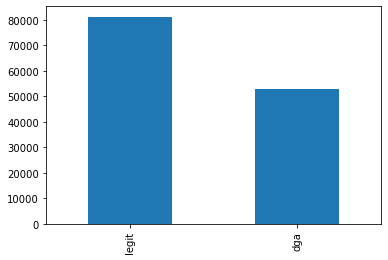

In [37]:
data_df["class"].value_counts().plot.bar()

## Observations on `class` Catagorical Data
While not perfectly balanced, there isn't a great imbalance between the two classes. Thus using stratified sampling should be a viable sampling method, without misrepresenting the ground truth.

For further robustness additional scoring metrics apart from accuracy should be used, as if our prior assumption around type 1 error (False Positive) being a worse outcome than a type 2 error, accuracy is not sufficient. Given that we have an imbalanced dataset we should consider another metric that accounts for this such as `f1-score`

## `subclass`

In [38]:
data_df["subclass"].value_counts()

legit           81261
cryptolocker    34319
newgoz          10999
goz              7347
Name: subclass, dtype: int64

In [39]:
pd.DataFrame(data_df["subclass"].value_counts()) / len(data_df)

,subclass
legit,0.606760
cryptolocker,0.256253
newgoz,0.082127
goz,0.054859


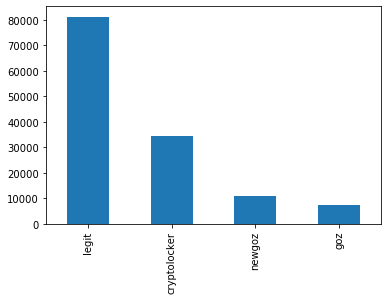

In [40]:
data_df["subclass"].value_counts().plot.bar()

## Observations on `subclass` Catagorical Data

For subclass there is a tail forming in the distribution, if accuracy in determining non `legit` subclasses is sub-par perhaps applying a resample technique such as bootstrapping in training may be required.

Accuracy will not be a sufficient metric given the imbalances in representation across `subclass`. If we take the view of a type 2 error (False Positive) is more undesireable than a type 1 error (False Negative) we should look to optimise model specificity and precision over accuracy.

# Distibutions of Quantitative Data

While there aren't any Quantitative fields in the dataset we can generate some simple values, such as length of string fields and occurances of characters in strings.

Furthermore converting our string data to numeric data will faciliate further quality checks.

## Top Level Domain

Let's split out the Top Level Domain (e.g. `com` from `google.com`) and so if there are any insights to be had.

In [41]:
data_df["tld"] = data_df["host"].apply(lambda x: ".".join(x.split(".")[1:]))

Let's look at the top 10 Top Level Domains.

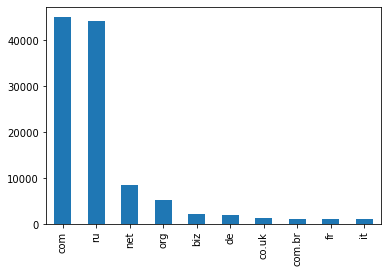

In [42]:
data_df["tld"].value_counts().head(10).plot.bar()


The number of of `com` TLDs is not that suprising as it is seen as a desirable domain for legitimate purposes.

The the number of `ru` TLDs is both suprising and not suprising upon reflection of potential bias in the collection of the dataset.

After the 4th most frequent TLD we have a long tailed distribution. 
We may not have enough observations if we stratify by `tld`, let's look at the interquartile ranges.

In [43]:
data_df["tld"].value_counts().describe()

count      723.000000
mean       185.236515
std       2377.449459
min          1.000000
25%          1.000000
50%          2.000000
75%         11.000000
max      45070.000000
Name: tld, dtype: float64

Let's group on TLD and class.

In [44]:
grouped_tld_class_df = data_df[["tld", "class", "domain"]].groupby(["tld", "class"]).agg("count")
grouped_tld_class_df.columns = ["occurrences"]
grouped_tld_class_df.head()

,,occurrences
tld,class,
ab.ca,legit,1
abruzzo.it,legit,1
ac,legit,4
ac.at,legit,1
ac.id,legit,5


The groupby operation will omit group combinations that do not exist, 

i.e. If there te combination of `za` lga and a `dga` class is not observed in the dataset then it will not appear in the grouped by dataset.

For our purposes we do want to be able to query which combinations do not exist.

Let's create an empty dataframe to join onto `grouped_tld_class_df` by using a multi-index built out of the product of `tld` and `class`.

In [45]:
tld_class_combinations = pd.MultiIndex.from_product([data_df["tld"].unique(),data_df["class"].unique()], names = ["tld", "class"])

# simple check that we have the expected number of combinations
assert(len(tld_class_combinations) == len(data_df["tld"].unique()) * len(data_df["class"].unique()))

empty_tld_class_combinations_df = pd.DataFrame(index=tld_class_combinations).reset_index()
empty_tld_class_combinations_df.head()

,tld,class
0,com.ar,legit
1,com.ar,dga
2,com,legit
3,com,dga
4,cn,legit


We'll join them on using a outer join so that combinations not present in the `grouped_tld_class_df` will have a known empty value `np.nan` in a new column 

In [46]:
grouped_tld_class_df.reset_index().head()

,tld,class,occurrences
0,ab.ca,legit,1
1,abruzzo.it,legit,1
2,ac,legit,4
3,ac.at,legit,1
4,ac.id,legit,5


In [47]:
exhaustive_tld_class_df = grouped_tld_class_df.reset_index().merge(
    empty_tld_class_combinations_df, 
    how = "outer", 
    on = ["tld", "class"],
    suffixes=("", "_empty"), 
    ).fillna(np.nan).sort_values(["tld", "class"])

In [48]:
exhaustive_tld_class_df.head()

,tld,class,occurrences
1187,ab.ca,dga,NaN
0,ab.ca,legit,1.0
1367,abruzzo.it,dga,NaN
1,abruzzo.it,legit,1.0
1006,ac,dga,NaN


How many tld do not have any `legit` observations?

In [49]:
missing_legit = exhaustive_tld_class_df[ 
                     (exhaustive_tld_class_df["occurrences"].isnull()) & 
                     (exhaustive_tld_class_df["class"] == "legit") 
                     ].shape[0]

print("missing_legit", missing_legit)

missing_legit 0


In [50]:
missing_legit / len(exhaustive_tld_class_df["tld"].unique())

0.0

How about tld without a `dga` observation?

In [51]:
missing_dga = exhaustive_tld_class_df[ 
                     (exhaustive_tld_class_df["occurrences"].isnull()) & 
                     (exhaustive_tld_class_df["class"] == "dga") 
                     ].shape[0]
                     
print("missing_dga", missing_dga)

missing_dga 718


718 Top Level Domains do not have a recorded observation of a `dga` class.

Let's express that as a ratio.


In [52]:
missing_dga / len(exhaustive_tld_class_df["tld"].unique())

0.9930843706777317

So which TLD have dga observations?

In [53]:
exhaustive_tld_class_df[ 
                     (~exhaustive_tld_class_df["occurrences"].isnull()) & 
                     (exhaustive_tld_class_df["class"] == "dga") 
                     ]

,tld,class,occurrences
44,biz,dga,1834.0
133,com,dga,2749.0
481,net,dga,3666.0
535,org,dga,2750.0
613,ru,dga,41666.0


Let's visualise the absolute difference between classes for our most frequently appearing `tld`.

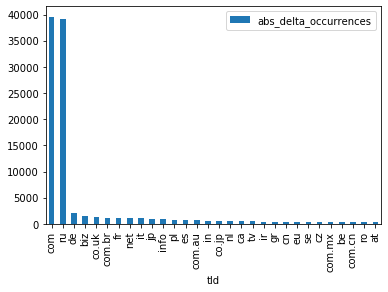

In [54]:
abs_difference_tld_class_df = exhaustive_tld_class_df.fillna(0).copy()
abs_difference_tld_class_df.loc[abs_difference_tld_class_df["class"] == "legit", "occurrences"] *= -1
abs_difference_tld_class_df = pd.DataFrame(abs_difference_tld_class_df.groupby("tld")["occurrences"].sum().abs()).sort_values("occurrences", ascending = False)
abs_difference_tld_class_df.columns = ["abs_delta_occurrences"]
abs_difference_tld_class_df.head(30).plot.bar()

Let's look at the breakdown of classess for the top two most frequent `tld`: `com` and `ru`.

In [55]:
com_by_class_df = grouped_tld_class_df.loc["com", :]
com_by_class_df["ratio"] = com_by_class_df["occurrences"] / com_by_class_df["occurrences"].sum()
com_by_class_df

,occurrences,ratio
class,,
dga,2749,0.060994
legit,42321,0.939006


In [56]:
ru_by_class_df = grouped_tld_class_df.loc["ru", :]
ru_by_class_df["ratio"] = ru_by_class_df["occurrences"] / ru_by_class_df["occurrences"].sum()
ru_by_class_df

,occurrences,ratio
class,,
dga,41666,0.942904
legit,2523,0.057096


## Observations on Top Level Domain

Given: 
* We do not have exhaustive observations for the product of `tld` and `class` ~99% of TLD do not have observations where class is `dga`
* The imbalance where there are observations for both `classes` is heavily skewed

Thus `tld` as a feature may be difficult to generalise.

## Length of Domain

Lets review if the length of a `domain` has any indication on the `class` of an observation.

In [57]:
domains_df = data_df[["domain", "class", "subclass"]].drop_duplicates()
domains_df.shape

(114525, 3)

In [58]:
domains_df["domain_len"] = domains_df["domain"].apply(len)

In [59]:
domains_len_stats_df = domains_df.groupby("class")["domain_len"].describe()
domains_len_stats_df

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,17.726764,5.946592,12.0,13.0,15.0,25.0,32.0
legit,61860.0,10.761752,3.300436,7.0,8.0,10.0,12.0,56.0


class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain_len, dtype: object

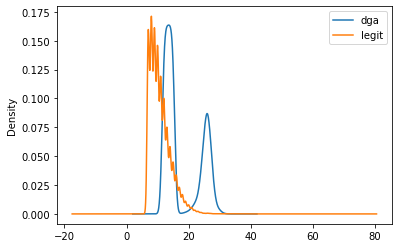

In [60]:
domains_df.groupby("class")["domain_len"].plot.kde(legend=True)

Looking a the `min` value there is something VERY interesting.

Let's review the interquartile values to get a better appreciation of the standard deviation values above.

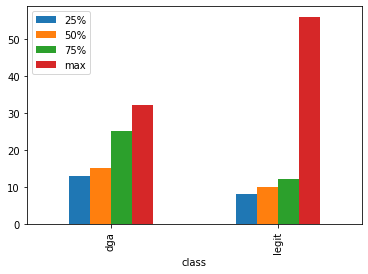

In [61]:
domains_len_stats_df[domains_len_stats_df.columns[4:]].plot.bar()

Let's have a look at these really long domains.

In [62]:
domains_df[domains_df["domain_len"] >= domains_len_stats_df["max"].min()].sort_values(["class", "subclass", "domain_len"]).set_index(["class", "subclass"])

domain  domain_len
class subclass                                                               
dga   goz                        fahqfqjnztfukbrsrsgerwqctkdeusjv          32
      goz                        lbpzkvfmemaiaqhyemijamofdqbuqkmj          32
      goz                        onwgbaaenvofifsoaqnvqokzfqlbmzxc          32
      goz                        ozuwydmfvkrwydgyhmmjfifmovnbrofu          32
      goz                        twqojncqtsfikbscqsaunfpjcakztkxo          32
      goz                        ydeudipztwgaaupvrkdqucbenfoncady          32
legit legit                      americansforresponsiblesolutions          32
      legit                      b117f8da23446a91387efea0e428392a          32
      legit                      bipolardisorderdepressionanxiety          32
      legit                      deutsche-wirtschafts-nachrichten          32
      legit                      ostsaechsische-sparkasse-dresden          32
      legit                     dellbackupandrecoverycloudstorage          33
      legit                     deutsche-mittelstands-nachrichten          33
      legit                 insearchoftheworldsmostbeautifulwoman          37
      legit                 sparkasse-oberlausitz-niederschlesien          37
      legit        article-directory-free-submission-free-content          46
      legit     gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...          56

The records that have the largest `domain_len` have repeating "words" that can be identified due to hyphen usuage. This might be a pattern that is repeated elsewhere. However it is doubtful that we could reliably generate a measure of "unique words" without implementing a dictionary which would be a considerable effort.

The other interesting quirk is the presence of `b117f8da23446a91387efea0e428392a` as a legit domain, it looks very much like a `dga` - is this perhaps a mislabeled observation?

Let's count the number of records that have a `domain_len` greater than the 75th percentile accross the classes

In [63]:
long_domains_by_class_df = pd.DataFrame(domains_df[domains_df["domain_len"] >= domains_len_stats_df["75%"].max()]["class"].value_counts())
long_domains_by_class_df

,class
dga,14643
legit,124


These long `legit` domains, what are they as a ratio of all legitimate domains in the dataset. 

In [64]:
long_domains_by_class_df.loc["legit"]["class"] / domains_len_stats_df.loc["legit"]["count"]

0.002004526349822179

## Observations on Length of Domain

For this we can deduce that in the dataset we've been given a `dga` record will have at a mimimum a domain of 12 characters long.

As for the maximum length where a record is `legit` having a `domain_len` >= 25 is the exception. Potentially we could discard these records, given they represent < 1% of all legit?

However there is more variation in the length of `domain` for `dga` records. But the fact there is a point of clear separation (< 12 characters in length), the length of the `domain` would be a useful feature.

There is a danger that `domain_len` might have undue importance due to the minimum length of 12 for `dga` - this is something that will need to be considered in model evaluation.

## Vowels

It would seem that vowels are common occurance across languages as per [Vowel Systems](https://en.wikipedia.org/wiki/Vowel#Systems) on Wikipedia.

There are some notable exceptions:
* `y` is considered a vowel in certain conditions
* `r` as a vowel in Czech and Slovak
* Danish has 13 vowels: (a) ɑ (ɐ) e ə ɛ i o ɔ u ø œ y

However given that DNS servers resolve non-ASCII characters into encoded ASCII characters we may find that all characters our dataset fall within the standard ASCII ordinal values.
If this holds true then we can generate feature on the presence of `['a','e','i','o','u','y']`.




### Vowel Counts
Let's generate a count for the vowels.

In [65]:
vowels = ["a", "e", "i", "o", "u", "y"]

Let's get the actual vowel counts

In [66]:
domain_letter_split = data_df["domain"].apply(lambda x: [w for w in x])

In [67]:
data_df["domain_vowel_count"] = domain_letter_split.apply(lambda x: len([w for w in x if w in vowels]))

In [68]:
data_df["domain_vowel_count"].describe()

count    133926.000000
mean          3.959873
std           1.730825
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          18.000000
Name: domain_vowel_count, dtype: float64

In [69]:
domain_by_class_vowel_stats_df = data_df[["class", "domain_vowel_count"]].groupby("class")["domain_vowel_count"].describe()
domain_by_class_vowel_stats_df

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,3.733960,1.929190,0.0,2.0,4.0,5.0,16.0
legit,81261.0,4.106287,1.571861,0.0,3.0,4.0,5.0,18.0


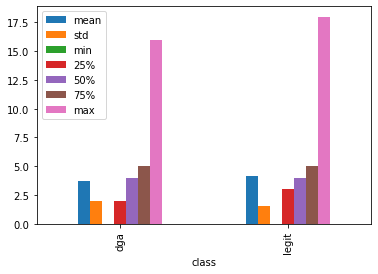

In [70]:
domain_by_class_vowel_stats_df[domain_by_class_vowel_stats_df.columns[1:]].plot.bar()

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain_vowel_count, dtype: object

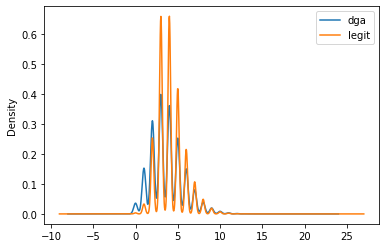

In [71]:
data_df[["class", "domain_vowel_count"]].groupby("class")["domain_vowel_count"].plot.kde(
    legend = True,
    )

Not much of a difference in the values between classes. Perhaps if we calculated the number of vowels as a ratio of length of the domain we might get better insights.

### Observations on Vowel Count

* Raw vowel count does not provide a clear boundary between `class`

### Vowel Ratios

In [72]:
data_df["domain_vowel_ratio"]  = data_df["domain_vowel_count"] / data_df["domain"].apply(len)

In [73]:
data_df[["class", "domain_vowel_ratio"]].groupby("class")["domain_vowel_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,0.219425,0.108766,0.0,0.142857,0.214286,0.285714,0.8
legit,81261.0,0.392103,0.095280,0.0,0.333333,0.400000,0.444444,0.9


Let's visualise the overlap

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain_vowel_ratio, dtype: object

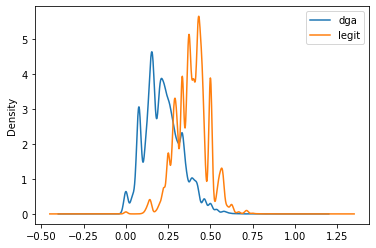

In [74]:
data_df[["class", "domain_vowel_ratio"]].groupby("class")["domain_vowel_ratio"].plot.kde(
    legend = True,
    )

In [75]:
data_df[["class", "domain_vowel_ratio"]].groupby("class")["domain_vowel_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,0.219425,0.108766,0.0,0.142857,0.214286,0.285714,0.8
legit,81261.0,0.392103,0.095280,0.0,0.333333,0.400000,0.444444,0.9


Lets see where how it plays out on IQR by class.

In [76]:
domain_by_class_vowel_ratio_stats_df = data_df[["class", "domain_vowel_ratio"]].groupby("class")["domain_vowel_ratio"].describe()
domain_by_class_vowel_ratio_stats_df

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,0.219425,0.108766,0.0,0.142857,0.214286,0.285714,0.8
legit,81261.0,0.392103,0.095280,0.0,0.333333,0.400000,0.444444,0.9


Given the 75th percentile of `domain_vowel_ratio` for `dga` is less than the 25th percentile for `legit` what is the overlap as a ratio?

In [77]:
number_of_dga_domain_vowel_ratio_overlap = len(data_df[(data_df["class"] == "dga") & (data_df["domain_vowel_ratio"] >= domain_by_class_vowel_ratio_stats_df.loc["dga"]["75%"])])
number_of_dga_domain_vowel_ratio_overlap / len(data_df[(data_df["class"] != "dga") & (data_df["domain_vowel_ratio"] >= 0)])

0.17640688645229569

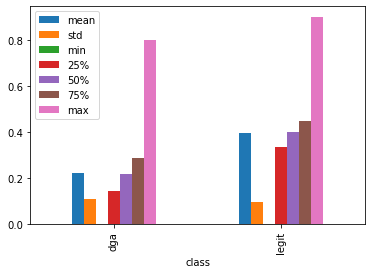

In [78]:
domain_by_class_vowel_ratio_stats_df[domain_by_class_vowel_ratio_stats_df.columns[1:]].plot.bar()

It would seem that `dga` class domains have fewer vowels in them as a ratio of all other letters.

This is potentially a useful feature for distinguishing, as the 25th percentile `domain_vowel_ratio` for `legit` is higher than the 75th percential `domain_vowel_ratio` for `dga`.

Although both have a minimum value of zero.

In [79]:
data_df[(data_df["domain_vowel_ratio"] == 0) & (data_df["class"] == "legit")].sample(5, random_state = 42)

,host,domain,class,subclass,tld,domain_vowel_count,domain_vowel_ratio
25925,clktrkng.com,clktrkng,legit,legit,com,0,0.0
18,0594666.com,0594666,legit,legit,com,0,0.0
28822,ctctcdn.com,ctctcdn,legit,legit,com,0,0.0
19050,blt17688.com,blt17688,legit,legit,com,0,0.0
481,12333sh.gov.cn,12333sh,legit,legit,gov.cn,0,0.0


In [80]:
data_df[(data_df["domain_vowel_ratio"] == 0) & (data_df["class"] != "legit")].sample(5, random_state = 42)

,host,domain,class,subclass,tld,domain_vowel_count,domain_vowel_ratio
23930,cgjrrcjmhncsdg.ru,cgjrrcjmhncsdg,dga,cryptolocker,ru,0,0.0
81955,nnpwfdspvwvpkk.ru,nnpwfdspvwvpkk,dga,cryptolocker,ru,0,0.0
31572,dgkhdkrdpwnkqh.ru,dgkhdkrdpwnkqh,dga,cryptolocker,ru,0,0.0
3142,1hb8cs91x80rctvsxtp91ks942n.net,1hb8cs91x80rctvsxtp91ks942n,dga,newgoz,net,0,0.0
90143,plcsrmvbrpkbs.ru,plcsrmvbrpkbs,dga,cryptolocker,ru,0,0.0


Seems that the `legit` domains that have a zero vowel count tend to have digits in them, whereas the `dga` domains do not.

Perhaps a similar measure for digits as a ratio of domain len would be beneficial.

Before we look into digits lets review the high `domain_vowel_ratio` records.

In [81]:
domain_vowel_ratio_75th_percentile_df = data_df[data_df["domain_vowel_ratio"] >= domain_by_class_vowel_ratio_stats_df["75%"].min()]

In [82]:
domain_vowel_ratio_75th_percentile_df.sample(5, random_state = 42)

,host,domain,class,subclass,tld,domain_vowel_count,domain_vowel_ratio
58155,inrixmedia.com,inrixmedia,legit,legit,com,5,0.500000
55681,iaosfbbjduor.ru,iaosfbbjduor,dga,cryptolocker,ru,5,0.416667
46101,gameduell.fr,gameduell,legit,legit,fr,4,0.444444
87534,patoghkade.com,patoghkade,legit,legit,com,4,0.400000
44644,freewebsiteadd.com,freewebsiteadd,legit,legit,com,6,0.428571


In [83]:
len(domain_vowel_ratio_75th_percentile_df) / len(data_df)

0.6515911772172692

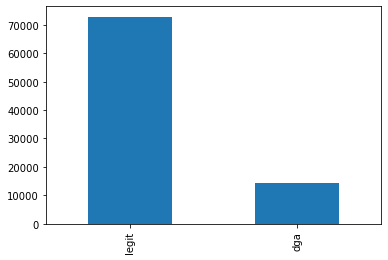

In [84]:
data_df[data_df["domain_vowel_ratio"] >= domain_by_class_vowel_ratio_stats_df["75%"].min()]["class"].value_counts().plot.bar()

In [85]:
data_df[data_df["domain_vowel_ratio"] >= domain_by_class_vowel_ratio_stats_df["max"].min()].sample(5, random_state = 42)

,host,domain,class,subclass,tld,domain_vowel_count,domain_vowel_ratio
132166,youyuan.com,youyuan,legit,legit,com,6,0.857143
130553,yahooeu.ru,yahooeu,legit,legit,ru,6,0.857143
7998,aaaauto.cz,aaaauto,legit,legit,cz,6,0.857143
86254,ouyaoxiazai.com,ouyaoxiazai,legit,legit,com,9,0.818182
42306,fiyeoyoeuijayag.ru,fiyeoyoeuijayag,dga,cryptolocker,ru,12,0.800000


Looking at the above a potential alternative would be to calculate the ratios based on distinct character counts.

In [86]:
data_df["domain_distinct"] = data_df["domain"].apply(lambda x: ''.join(set(x)))
data_df[["domain", "domain_distinct"]].head()

,domain,domain_distinct
0,000directory,riyect0do
1,000webhost,bshet0ow
2,001fans,1sfn0a
3,01-telecharger,1rghect0l-a
4,010shangpu,1sghnu0ap


In [87]:
data_df["domain_distinct_vowel_count"] = data_df["domain_distinct"].apply(lambda x: len([w for w in x if w in vowels]))
data_df["domain_distinct_vowel_ratio"] = data_df["domain_distinct_vowel_count"] / data_df["domain_distinct"].apply(len)

Lets look at the overlap again

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain_distinct_vowel_ratio, dtype: object

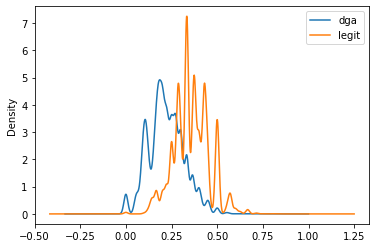

In [88]:
data_df[["class", "domain_distinct_vowel_ratio"]].groupby("class")["domain_distinct_vowel_ratio"].plot.kde(legend = True)

In [89]:
domain_distinct_vowel_ratio_stats_df = data_df[["class", "domain_distinct_vowel_ratio"]].groupby("class")["domain_distinct_vowel_ratio"].describe()
domain_distinct_vowel_ratio_stats_df

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
dga,52665.0,0.221543,0.096206,0.0,0.166667,0.214286,0.277778,0.666667
legit,81261.0,0.358638,0.097000,0.0,0.285714,0.357143,0.428571,0.833333


In [90]:
number_of_dga_domain_distinct_vowel_ratio_overlap = len(data_df[(data_df["class"] == "dga") & (data_df["domain_distinct_vowel_ratio"] >= domain_by_class_vowel_ratio_stats_df.loc["dga"]["75%"])])
number_of_dga_domain_distinct_vowel_ratio_overlap / len(data_df)
number_of_dga_domain_distinct_vowel_ratio_overlap / len(data_df[(data_df["class"] != "dga") & (data_df["domain_vowel_ratio"] >= 0)])

0.1596829967635151

It would seem we've reduced the overlap by ~ 2 percent for `dga` records having a `domain_distinct_vowel_ratio` above the 75th percentile overlapping with `legit` records.

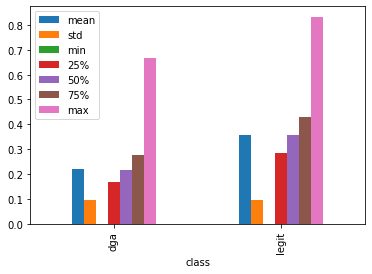

In [91]:
domain_distinct_vowel_ratio_stats_df[domain_distinct_vowel_ratio_stats_df.columns[1:]].plot.bar()

### Observations on Vowel Ratios

* Vowel Ratios have some discriminatory value between the `class` values.
* Vowlel Ratios that are calculated on the distinct character counts provide a nominal improvement.

## Digits

As we saw during Vowel Ratio analysis domains with a low to zero vowel count tended to have numbers present.

Let's generate similar measures for the counts of digits present.

In [92]:
digits = ["0","1","2","3","4","5","6","7","8","9"]

In [93]:
data_df["digit_count"] = domain_letter_split.apply(lambda x: len([w for w in x if w in digits]))

In [94]:
data_df["digit_count"].describe()

count    133926.000000
mean          0.759136
std           2.466659
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.000000
Name: digit_count, dtype: float64

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: digit_count, dtype: object

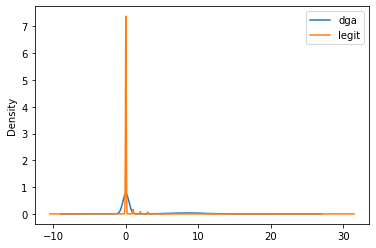

In [95]:
data_df[["class", "digit_count"]].groupby("class")["digit_count"].plot.kde(legend = True)

That's a bit difficult to read, let's limit it to just the records where `domain_vowel_ratio` is zero.

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: digit_count, dtype: object

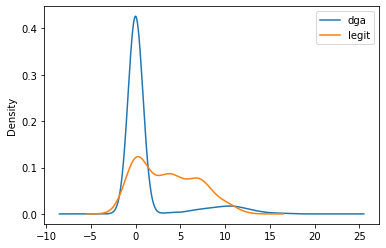

In [96]:
data_df[(data_df["domain_vowel_ratio"] == 0)][["class", "digit_count"]].groupby("class")["digit_count"].plot.kde(legend = True)

Based on the above, further exploration of ratios and distinctness is unlikely to yield a better boundary between our classes.

## Observations on Digits

There is some discriminating value in counting the number of digits, in that where the `vowel_ratio` is zero non legit domains have an increased likelyhood of having a zero `digit_count`.

## Vowel Distances

Another hallmark of words that are sensible to humans is the distance between vowel characters.

In [97]:
data_df[data_df["class"] == "legit"][["domain"]].sample(5, random_state=6)

,domain
92284,prof-klub
91705,preguntados
51166,hanselman
35432,earnparttimejobs
25817,clickthecity


In [98]:
data_df[data_df["class"] == "dga"][["domain"]].sample(5, random_state=6)

,domain
29342,cxccqpkrjieafcd
1108,15g8f6p19cd8h01gar4ueu39g0c
123240,vvhakmoabppjlku
79389,n0wkjoqhy1r9xby98i1buvwne
113764,todairobmamciukjnbheqhce


Simply eyeballing the data above we can see that in some cases of `dga` records the occurances of vowels is more sparse.

If we construct a measure of this sparsity it may be heplful in distinguishing between the classes. Additionally we'll measure the distances as if we are reading left to right, this does mean that non left to right languages will be penalised.

In [99]:
from typing import List, Callable
from numbers import Number
from scipy.stats import mode
import numpy as np
import pandas as pd


def character_distance_left_right(text: str, ords_to_search_for: List[int]) -> np.array:
    if len(text) == 0:
        raise ValueError("Must pass in valid value for `text`")

    if len(ords_to_search_for) == 0:
        raise ValueError("Must pass in valid value for `ords_to_search_for`")

    if not(all([isinstance(x, Number) for x in ords_to_search_for])):
        raise TypeError("Invalid data type in `ords_to_search_for` expected Number")

    ord_text = np.array([ord(x) for x in text])

    match_indexes = np.argwhere(np.isin(ord_text, ords_to_search_for)).flatten()

    if match_indexes.size == 0:
        return np.array(len(text))

    it = np.nditer(ord_text, flags=['f_index'])
    last_vowel_index = 0

    result = list()
    while not it.finished:
        result_matches = match_indexes - it.index
        forward_matches = result_matches[result_matches >= 0]

        if forward_matches.size > 0:
            result.append(forward_matches.min())
            last_vowel_index = it.index
        else:
            result.append(it.index - last_vowel_index)

        it.iternext()

    return np.array(result)


def vowel_distance_left_right_in_column(series: pd.Series, distance_function: Callable) -> pd.Series:
    if not isinstance(distance_function, Callable):
        raise TypeError("`distance_function` must be callable")

    vowel_ords = [ord(x) for x in ["a", "e", "i", "o", "u", "y"]]

    column_len = series.astype(str).apply(len)
    search_for_ords_distances = series.astype(str).apply(lambda x: character_distance_left_right(x, vowel_ords))
    search_for_ords_distances = search_for_ords_distances.apply(distance_function) / column_len
    search_for_ords_distances = search_for_ords_distances.clip(upper = 1.0)
    search_for_ords_distances = search_for_ords_distances.fillna(1.0)

    return search_for_ords_distances


def vowel_mode_distance_left_right_in_column(series: pd.Series) -> pd.Series:

    def get_mode(x: np.array) -> np.float64:
        result = mode(x)

        if result[1][0] > 1:
            return mode(x)[0][0]
        else:
            # there was no identifiable mode return np.nan
            return np.nan

    return vowel_distance_left_right_in_column(series, get_mode)


In [100]:
character_distance_left_right("hello", [ord(x) for x in ["e","o"]])

array([1, 0, 2, 1, 0], dtype=int64)

In [101]:
character_distance_left_right("hello", [ord(x) for x in ["e"]])

array([1, 0, 1, 2, 3], dtype=int64)

In [102]:
character_distance_left_right("zzzzzzzze", [ord(x) for x in ["e"]])

array([8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64)

In [103]:
character_distance_left_right("ezzzzzzzz", [ord(x) for x in ["e"]])

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [104]:
def search_for_ords_distances(df, column, search_for, label):
    result_df = df[["class"]].copy()
    search_for_ords = [ord(x) for x in search_for ]
    
    col_lengths = df[column].apply(len)

    result_df[f"{column}_{label}_distance_mean_ratio"] = vowel_distance_left_right_in_column(df[column], np.mean)
    result_df[f"{column}_{label}_distance_std_ratio"] = vowel_distance_left_right_in_column(df[column], np.std)
    result_df[f"{column}_{label}_distance_max_ratio"] = vowel_distance_left_right_in_column(df[column], np.max)
    result_df[f"{column}_{label}_distance_min_ratio"] = vowel_distance_left_right_in_column(df[column], np.min)
    result_df[f"{column}_{label}_distance_median_ratio"] = vowel_distance_left_right_in_column(df[column], np.median)
    result_df[f"{column}_{label}_distance_mode_ratio"] = vowel_mode_distance_left_right_in_column(df[column])
    
    return result_df

In [105]:
distances_df = search_for_ords_distances(data_df, "domain", ["a","e", "i", "o", "u"], "vowel")

In [106]:
distances_df.head()

,class,domain_vowel_distance_mean_ratio,domain_vowel_distance_std_ratio,domain_vowel_distance_max_ratio,domain_vowel_distance_min_ratio,domain_vowel_distance_median_ratio,domain_vowel_distance_mode_ratio
0,legit,0.104167,0.102768,0.333333,0.0,0.083333,0.000000
1,legit,0.160000,0.120000,0.400000,0.0,0.150000,0.100000
2,legit,0.265306,0.177914,0.571429,0.0,0.285714,0.142857
3,legit,0.091837,0.082898,0.285714,0.0,0.071429,0.071429
4,legit,0.210000,0.157797,0.500000,0.0,0.200000,0.000000


In [107]:
distances_df.describe()

,domain_vowel_distance_mean_ratio,domain_vowel_distance_std_ratio,domain_vowel_distance_max_ratio,domain_vowel_distance_min_ratio,domain_vowel_distance_median_ratio,domain_vowel_distance_mode_ratio
count,133926.000000,133926.000000,133926.000000,133926.000000,133926.000000,133926.000000
mean,0.127635,0.103519,0.324496,0.008647,0.117080,0.041880
std,0.108137,0.049880,0.172109,0.092584,0.105785,0.120629
min,0.010000,0.000000,0.045455,0.000000,0.000000,0.000000
25%,0.073964,0.070511,0.200000,0.000000,0.071429,0.000000
50%,0.102041,0.092807,0.285714,0.000000,0.100000,0.000000
75%,0.148148,0.125000,0.400000,0.000000,0.142857,0.071429
max,1.000000,0.288491,1.000000,1.000000,1.000000,1.000000


In [108]:
pd.DataFrame(distances_df.corr())

,domain_vowel_distance_mean_ratio,domain_vowel_distance_std_ratio,domain_vowel_distance_max_ratio,domain_vowel_distance_min_ratio,domain_vowel_distance_median_ratio,domain_vowel_distance_mode_ratio
domain_vowel_distance_mean_ratio,1.000000,0.474435,0.862796,0.753417,0.961631,0.734087
domain_vowel_distance_std_ratio,0.474435,1.000000,0.826758,-0.193823,0.354248,0.040495
domain_vowel_distance_max_ratio,0.862796,0.826758,1.000000,0.366551,0.760031,0.446619
domain_vowel_distance_min_ratio,0.753417,-0.193823,0.366551,1.000000,0.779481,0.741782
domain_vowel_distance_median_ratio,0.961631,0.354248,0.760031,0.779481,1.000000,0.769051
domain_vowel_distance_mode_ratio,0.734087,0.040495,0.446619,0.741782,0.769051,1.000000


In [109]:
import matplotlib.pyplot as plt

In [110]:
melted_distances_df = distances_df.melt(id_vars="class")
melted_distances_df.sample(5)

,class,variable,value
294760,legit,domain_vowel_distance_max_ratio,0.095238
271775,dga,domain_vowel_distance_max_ratio,0.720000
270714,dga,domain_vowel_distance_max_ratio,0.360000
431833,legit,domain_vowel_distance_min_ratio,0.000000
320015,legit,domain_vowel_distance_max_ratio,0.222222


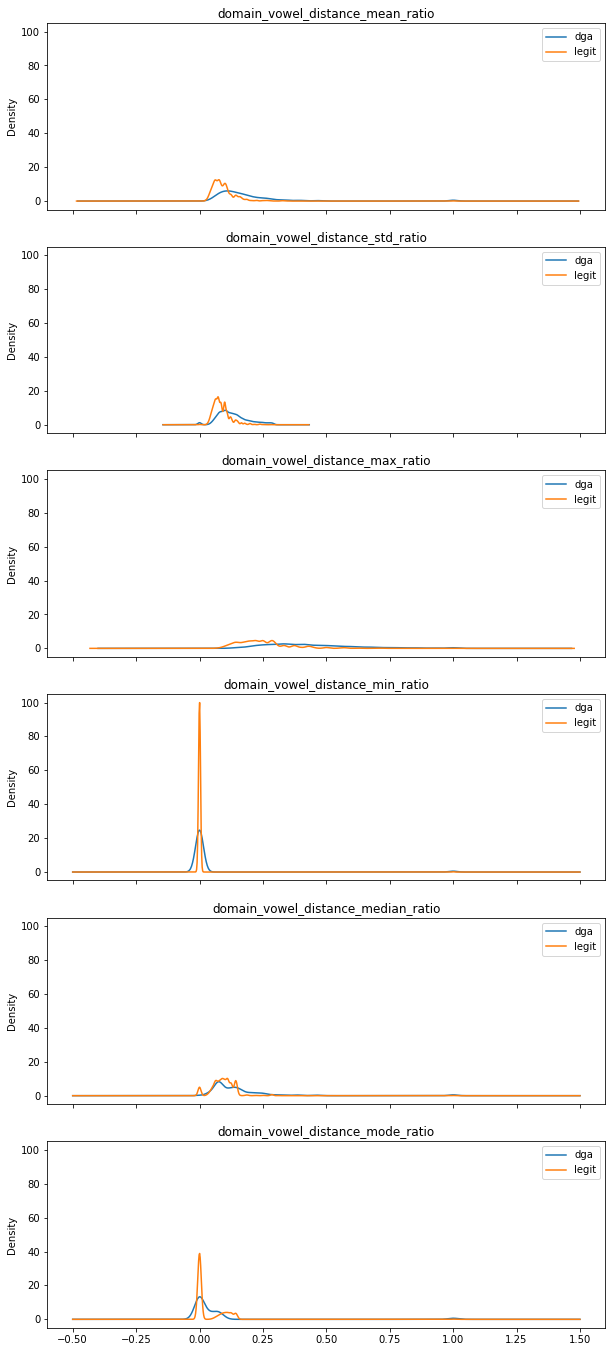

In [111]:
unique_distance_vars = melted_distances_df["variable"].unique()

fig, ax = plt.subplots(figsize=(10,4 * len(unique_distance_vars)), ncols = 1, nrows = len(unique_distance_vars), sharey='all', sharex=True)

for i, variable in enumerate(unique_distance_vars):
    melted_distances_df[melted_distances_df["variable"] == variable].groupby("class")["value"].plot.kde(
        legend = True, 
        title = variable, 
        ax = ax[i],
        stacked = True,
    )

Let's remove `domain_vowel_distance_min_ratio` from consideration, as its peaks between the classes center on the same values.

While `domain_vowel_distance_mode_ratio` also shares a peak between the classes there is a some distinction between the class after this first peak. Thus we'll keep it in consideration.

In [112]:
melted_distances_df = melted_distances_df[~melted_distances_df["variable"].isin(["domain_vowel_distance_min_ratio"])]

Let's replot given we're removed features from consideration.

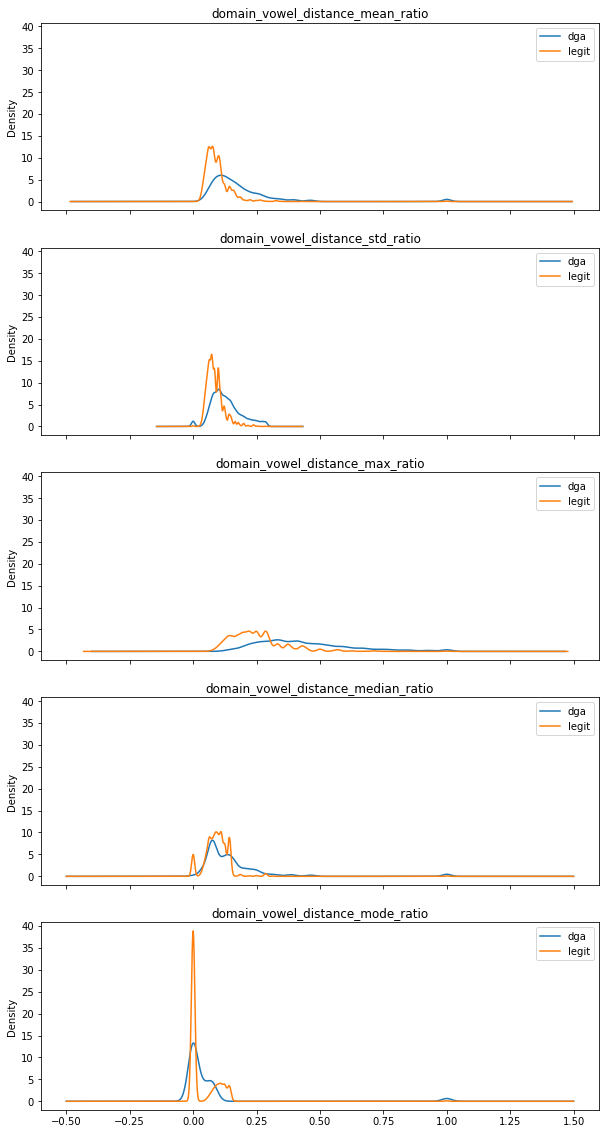

In [113]:
unique_distance_vars = melted_distances_df["variable"].unique()

fig, ax = plt.subplots(figsize=(10,4 * len(unique_distance_vars)), ncols = 1, nrows = len(unique_distance_vars), sharey='all', sharex=True)

for i, variable in enumerate(unique_distance_vars):
    melted_distances_df[melted_distances_df["variable"] == variable].groupby("class")["value"].plot.kde(
        legend = True, 
        title = variable, 
        ax = ax[i],
    )

Now a question must be asked of the remaing vowel distance features, which features are highly correlated. That is if two features are highly correlated then we should not include them both as the information gain would not be worth the additional complexity in our model.

In [114]:
distances_df[unique_distance_vars].corr()

,domain_vowel_distance_mean_ratio,domain_vowel_distance_std_ratio,domain_vowel_distance_max_ratio,domain_vowel_distance_median_ratio,domain_vowel_distance_mode_ratio
domain_vowel_distance_mean_ratio,1.000000,0.474435,0.862796,0.961631,0.734087
domain_vowel_distance_std_ratio,0.474435,1.000000,0.826758,0.354248,0.040495
domain_vowel_distance_max_ratio,0.862796,0.826758,1.000000,0.760031,0.446619
domain_vowel_distance_median_ratio,0.961631,0.354248,0.760031,1.000000,0.769051
domain_vowel_distance_mode_ratio,0.734087,0.040495,0.446619,0.769051,1.000000


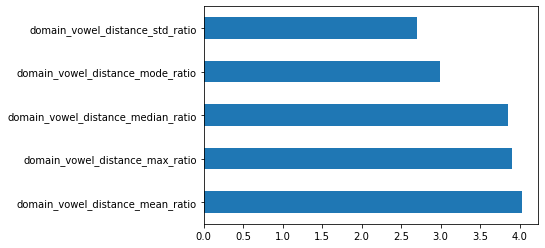

In [115]:
distances_df[unique_distance_vars].corr().abs().sum().sort_values(ascending = False).plot.barh()

## Observations on Vowel Distances

Looking at the correlation table and barplot of absolute correlation magnitudes, we will take `domain_vowel_distance_std_ratio` and `domain_vowel_distance_mode_ratio` forward.

Furthermore given the above are expressed as ratios they will not be prone to the issues of length based measures for misclassification.

## Most Frequent Consonants

We've been paying a fair bit of attention to vowels, however it would also be prudent to consider the consonants.

Eyeballing the data `dga` observations a variety of consonants and repeating consonants are not uncommon. Is there anything to this hunch?

In [116]:
from collections import Counter

In [117]:
def get_consonant_variety_ratio(s):
    s = "".join([c for c in list(s) if c not in ["a","e","i","o","u","y"]])
  
    if len(s) == 0:
        return 0.0

    counter = Counter(s)
    counts = np.array(list(counter.values()))
  
    if np.min(counts) == np.max(counts):
        return 1

    return np.max(counts) / np.sum(counts)

In [118]:
data_df["domain_consonant_variety_ratio"] = data_df["domain"].apply(lambda x: get_consonant_variety_ratio(x) )

class
dga      AxesSubplot(0.125,0.125;0.775x0.755)
legit    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain_consonant_variety_ratio, dtype: object

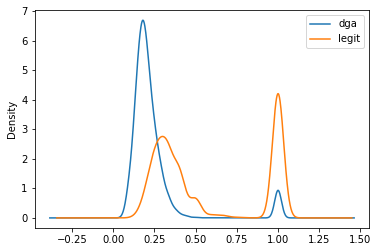

In [119]:
data_df.groupby("class")["domain_consonant_variety_ratio"].plot.kde(legend=True)

## Character Pair Windows

A typical step in natural language processing is to tokenize the documents, and then convert the tokenized representation into a numerical representation of the document e.g. Bag of Words, n_grams, Word Vectors.

Let's take a slightly naive approach and create a sliding 2 character window over our domains, from this we can find the most frequently occuring two character pairs across the classes. 

The rationale is that in languages there are certain characters that will frequently appear alongside another. We will build this window in a left to right fashion which does present a limitation for right to left languages.


In [120]:
from itertools import islice

def text_window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

Now let's bring the class back in

In [121]:
domain_windowed = data_df["domain"].apply(lambda x: ["".join(y) for y in text_window(x, 2)])

In [122]:
domain_windowed.head()

0         [00, 00, 0d, di, ir, re, ec, ct, to, or, ry]
1                 [00, 00, 0w, we, eb, bh, ho, os, st]
2                             [00, 01, 1f, fa, an, ns]
3    [01, 1-, -t, te, el, le, ec, ch, ha, ar, rg, g...
4                 [01, 10, 0s, sh, ha, an, ng, gp, pu]
Name: domain, dtype: object

Let's encode the above into a sparsely populated dataframe in a similar fashion to one hot encoding.

In [123]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

domain_windows_df = pd.DataFrame(mlb.fit_transform(domain_windowed), columns = mlb.classes_, index=data_df.index)
domain_windows_df.head()

,\nd,--,-0,-1,-2,-3,-4,-5,-6,-7,...,zq,zr,zs,zt,zu,zv,zw,zx,zy,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's being class back in.

In [124]:
domain_windows_columns = list(domain_windows_df.columns)
domain_windows_df["class"] = data_df["class"]
domain_windows_df = domain_windows_df[["class"] + domain_windows_columns]

In [125]:
domain_windows_df.head()

,class,\nd,--,-0,-1,-2,-3,-4,-5,-6,...,zq,zr,zs,zt,zu,zv,zw,zx,zy,zz
0,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll melt aggregate and melt the dataframe above so we have summed totals.

In [126]:
domain_windows_count_by_class_df = domain_windows_df.groupby(["class"]).sum()
domain_windows_count_by_class_df = domain_windows_count_by_class_df.reset_index().melt(id_vars="class").groupby(["class", "variable"]).sum().sort_values("value", ascending = False)
domain_windows_count_by_class_df.head()

value
class variable       
legit in        12805
      er        12336
      re        10424
      an         9890
      es         9260

For the purposes of visualising we'll need a count of total records by class type.

In [127]:
total_class_counts = data_df["class"].value_counts()
total_class_counts.name = "total"

As we increase the number of pairs we consider the greater the likelihood of getting matches in both the `legit` and `dga` class.

Let's gradually increase the number of pairs we're considering and plot the matches compared the total count per class.

In [128]:
def display_matching_pairs(windows_count_by_class_df, domain_class, max_pairs, total_class_counts, data_df, domain_windows_df):
    matches = list()

    grid_col_size = 4

    fig, ax = plt.subplots(
        figsize=(5 * grid_col_size, 4 * (max_pairs // grid_col_size)), 
        ncols = grid_col_size, 
        nrows = (max_pairs // grid_col_size)
    )

    character_pairs = windows_count_by_class_df.loc[domain_class, :].sort_values(
        "value", ascending = False
    ).head(max_pairs).reset_index()["variable"].values
    
    print(f"top {max_pairs} character pairs for {domain_class}:", character_pairs)

    for i in range(0, max_pairs):
        class_matching_character_pairs = data_df[(domain_windows_df[character_pairs[:i+1]] > 0).apply(any, axis = 1)]["class"].value_counts()
        class_matching_character_pairs.name = f"{i+1}"
        matches.append(class_matching_character_pairs)

        pd.DataFrame( [ total_class_counts, class_matching_character_pairs] ).T.plot.barh(legend="True", ax = ax[i // grid_col_size, i % grid_col_size])

    return pd.DataFrame(matches)

top 20 character pairs for legit: ['in' 'er' 're' 'an' 'es' 'ar' 'on' 'or' 'st' 'ne' 'te' 'li' 'al' 'ra'
 'en' 'ma' 'me' 'to' 'ti' 'le']


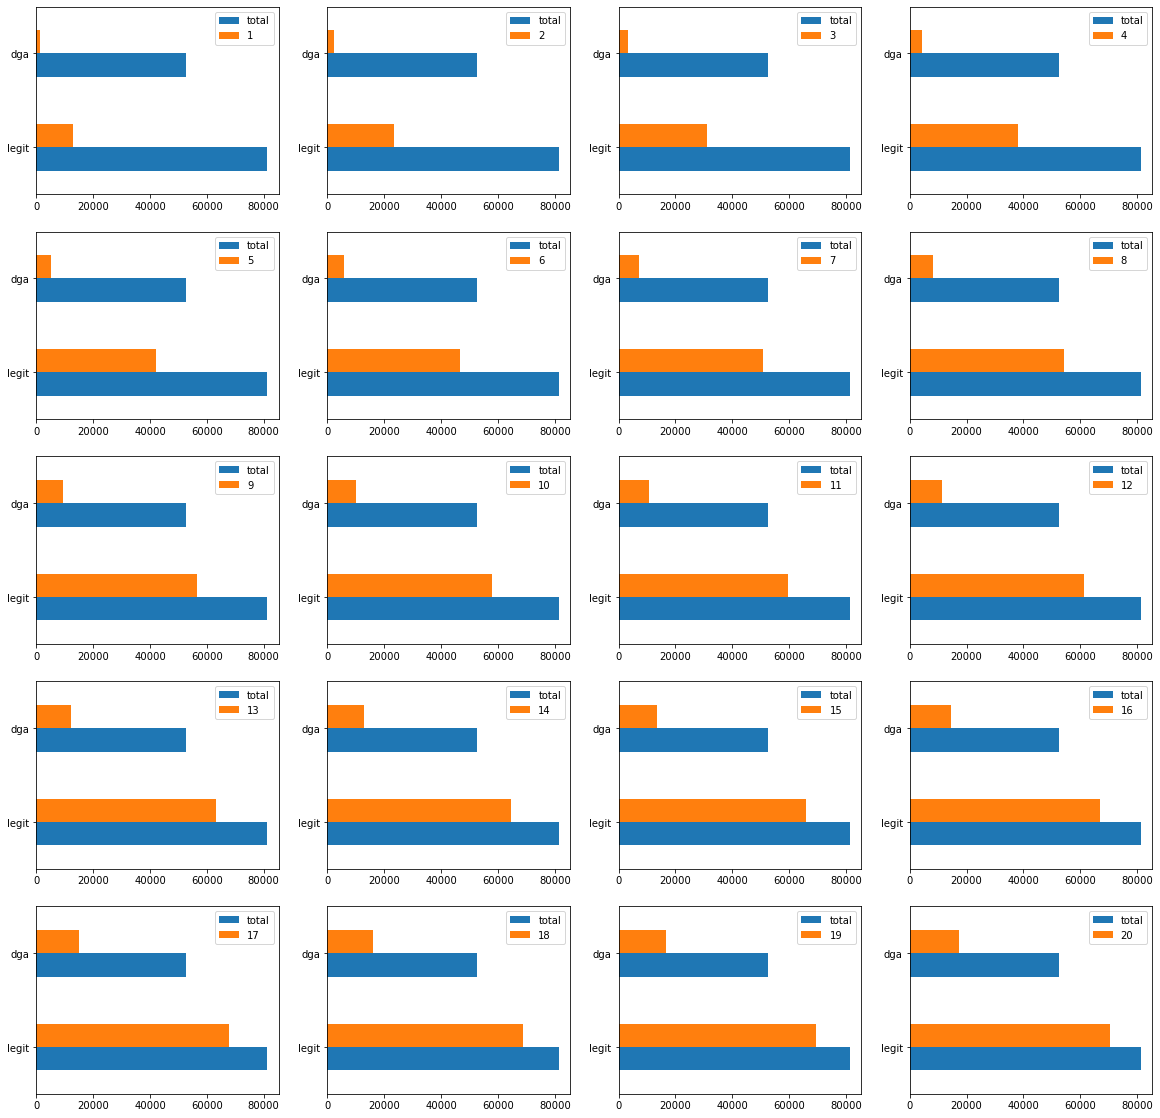

In [129]:
legit_pair_matches_df = display_matching_pairs(domain_windows_count_by_class_df, "legit", 20, total_class_counts, data_df, domain_windows_df)

 Lets we visualise the growth as we increase the number of pairs as a line plot.

In [130]:
legit_pair_matches_df["diff"] = legit_pair_matches_df["legit"] - legit_pair_matches_df["dga"]

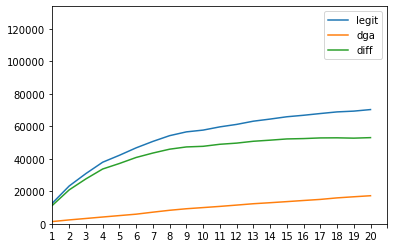

In [131]:
legit_pair_matches_df.plot(legend=True, ylim=(0,len(data_df)), xticks=range(0,21))

The change in `dga` matches seems to be almost linear, let's investigate the rate of change as a gradient to identify where the plateau effect kicks in.

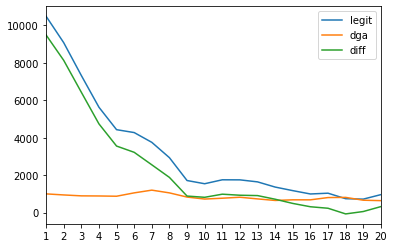

In [132]:
ax = (legit_pair_matches_df.apply(np.gradient)).apply(pd.Series).plot(
    xticks=np.arange(20)
)
ax = ax.set_xticklabels(list(range(1,21)))

It would seem the plateau kicks in good and proper from 9 pairs onwards. 

Let's review the above but for the top pairs for `dga` .

top 20 character pairs for dga: ['yh' 'kb' 'yp' 'cu' 'yt' 'yl' 'yx' 'ws' 'qk' 'yd' 'fu' 'oj' 'rc' 'uk'
 'nb' 'hu' 'lj' 'mr' 'tk' 'lr']


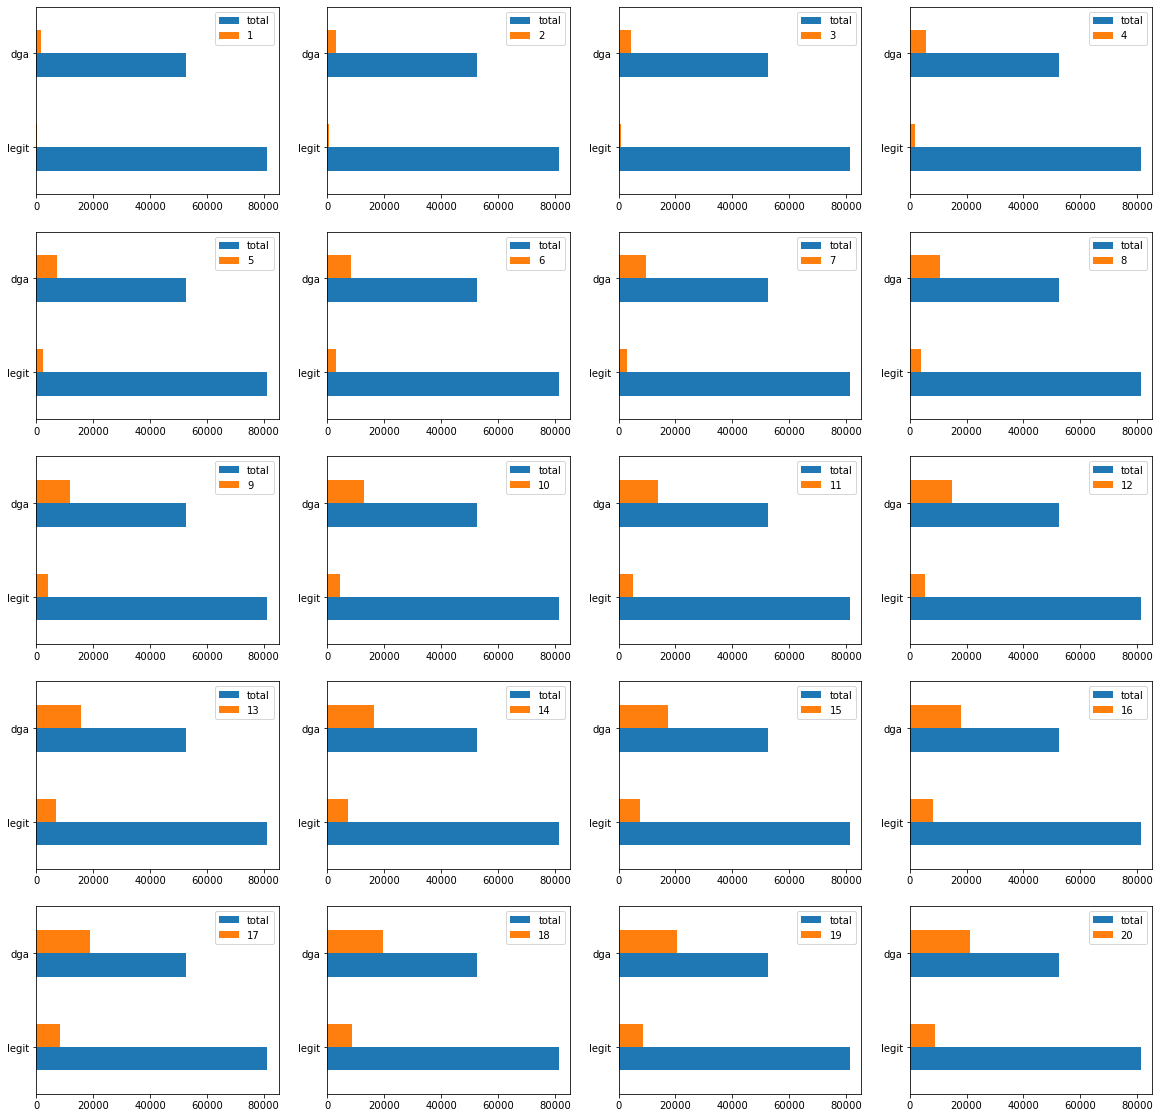

In [133]:
dga_pair_matches_df = display_matching_pairs(domain_windows_count_by_class_df, "dga", 20, total_class_counts, data_df, domain_windows_df)

In [134]:
dga_pair_matches_df["diff"] = dga_pair_matches_df["dga"] - dga_pair_matches_df["legit"]

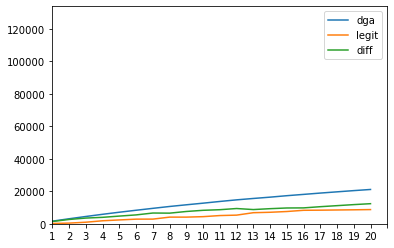

In [135]:
dga_pair_matches_df.plot(legend=True, ylim=(0,len(data_df)), xticks=range(0,21))

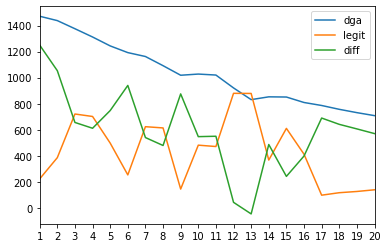

In [136]:
ax = (dga_pair_matches_df.apply(np.gradient)).apply(pd.Series).plot(
    xticks=np.arange(20)
)
ax = ax.set_xticklabels(list(range(1,21)))

It would seem the frequent character pairs for `dga` entries when considered for the entire dataset aren't illustrative. The rate of growth in `legit` classes outpaces `dga` matches at a number of steps as we increase the number of pairs to be considered.

This would suggest these word pairs are perhaps too noisy to be considered as features in our model.

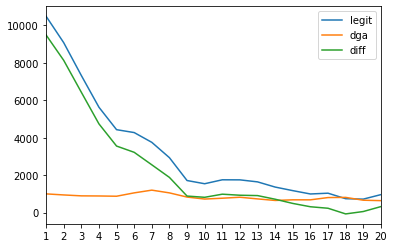

In [137]:
ax = (legit_pair_matches_df.apply(np.gradient)).apply(pd.Series).plot(
    xticks=np.arange(20)
)
ax = ax.set_xticklabels(list(range(1,21)))

Let's take the top 10 most frequently occuring word pairs in the dataset for `legit` entries.

In [138]:
legit_character_pairs = domain_windows_count_by_class_df.loc["legit", :].\
    sort_values("value", ascending = False).head(10).reset_index()["variable"].values

legit_character_pairs

array(['in', 'er', 're', 'an', 'es', 'ar', 'on', 'or', 'st', 'ne'],
      dtype=object)

In [139]:
class_matching_legit_character_pairs = data_df[(domain_windows_df[legit_character_pairs] > 0).\
                                                   apply(any, axis = 1)]["class"].value_counts()

class_matching_legit_character_pairs.name = "matching"

Now let's plot the number of domains that contain any of the `legit_character_pairs` by class.

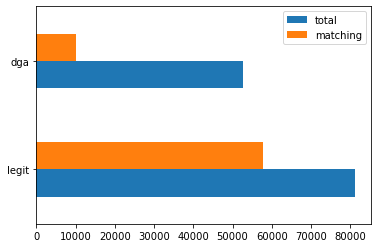

In [140]:
pd.DataFrame( [ total_class_counts, class_matching_legit_character_pairs] ).T.plot.barh()

Let's get the top most occurring `dga` character pairs.

In [141]:
dga_character_pairs = domain_windows_count_by_class_df.loc["dga", :].sort_values("value", ascending = False).head(10).reset_index()["variable"].values
dga_character_pairs

array(['yh', 'kb', 'yp', 'cu', 'yt', 'yl', 'yx', 'ws', 'qk', 'yd'],
      dtype=object)

Now let's plot the number of domains that contain any of the `dga_character_pairs` by class.

In [142]:
class_matching_dga_character_pairs = data_df[(domain_windows_df[dga_character_pairs] > 0).apply(any, axis = 1)]["class"].value_counts()
class_matching_legit_character_pairs.name = "matching"

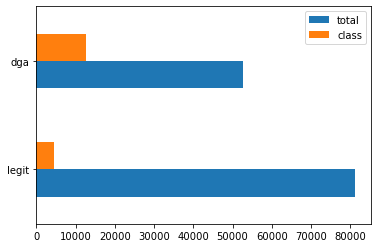

In [143]:
pd.DataFrame( [ total_class_counts, class_matching_dga_character_pairs] ).T.plot.barh()

## Observations on Character Pair Windows

Taking a sample windowed character pairs from `legit` domains ordered by their frequency of appearance as a feature may provide some discriminatory value. The `dga` character pairs are too noisy, probably a result the `words` being generated.

# Frequency Analysis

If we assigned classes based on their frequency what level of accuracy would we achieve?

In [144]:
def get_probabilities(df, column):
    return (pd.DataFrame(df[column].value_counts()) / len(df)).to_dict()[column]

In [145]:
class_probabilities = get_probabilities(data_df, "class")
class_probabilities

{'legit': 0.6067604498006361, 'dga': 0.39323955019936385}

In [146]:
def random_prob_assignment(probabilities_dict):
    return np.random.choice(list(probabilities_dict.keys()), p = list(probabilities_dict.values()))

In [147]:
def probability_assignment_accuracy(df, column, probabilities_dict):
    assigned_values = df[column].apply(lambda x: random_prob_assignment(probabilities_dict))
    return len(df[assigned_values == df[column]]) / len(df)

In [148]:
number_of_trials = 10
class_probability_assignment_trials = pd.Series([probability_assignment_accuracy(data_df, "class", class_probabilities) for x in range(number_of_trials)])

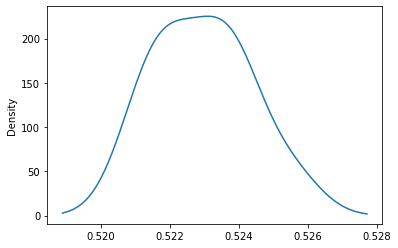

In [149]:
class_probability_assignment_trials.plot.kde()

In [150]:
class_probability_assignment_trials.describe()

count    10.000000
mean      0.522942
std       0.001389
min       0.521086
25%       0.521881
50%       0.522946
75%       0.523845
max       0.525499
dtype: float64

Assigning the class based on frequency seems to converge on 52% accuracy, so a favourable coin toss.

In [151]:
subclass_probabilities = get_probabilities(data_df, "subclass")
subclass_probabilities

{'legit': 0.6067604498006361,
 'cryptolocker': 0.2562534533996386,
 'newgoz': 0.08212744351358213,
 'goz': 0.054858653286143096}

In [152]:
number_of_trials = 10
subclass_probability_assignment_trials = pd.Series([probability_assignment_accuracy(data_df, "subclass", subclass_probabilities) for x in range(number_of_trials)])

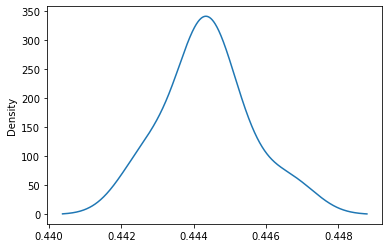

In [153]:
subclass_probability_assignment_trials.plot.kde()

In [154]:
subclass_probability_assignment_trials.describe()

count    10.000000
mean      0.444362
std       0.001168
min       0.442476
25%       0.444122
50%       0.444279
75%       0.444718
max       0.446687
dtype: float64

## Observations on Frequency Analysis

If we developed a model purely on frequency of class we'd expect an accuaracy of ~52%

We could certainly do better with the application of appropriate models.